<a href="https://colab.research.google.com/github/vkaramanis/Coursera_Capstone/blob/main/The_Battle_of_Neighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Let's assume that there is a small travel agency that wants to personalize its recommendations depending on the clients' preferences. This will enable the agency to understand how similar are different places and provide targeted suggestions to clients that have particular preferences.

Such a move will be beneficial for the clients too as they will have the opportunity to visit places that they most probably like rather than randomly visiting a place.

To do that we will use forthsquare's top picks for the 100 most popular destinations according to wikipedia [List_of_cities_by_international_visitors](https://en.wikipedia.org/wiki/List_of_cities_by_international_visitors).

We will classify the cities based on the similarities they have on these top picks. Based on this classification we will find which are the key characteristics for each group of cities. This will enable us to provide targeted suggestions to future clients.


# Part 1
Load and clean data

In [69]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import folium
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

In [6]:
headers = {
    'Access-Control-Allow-Origin': '*',
    'Access-Control-Allow-Methods': 'GET',
    'Access-Control-Allow-Headers': 'Content-Type',
    'Access-Control-Max-Age': '3600',
    'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0'
    }

url = "https://en.wikipedia.org/wiki/List_of_cities_by_international_visitors"
req = requests.get(url, headers)
soup = BeautifulSoup(req.content, 'html.parser')

In [91]:
table = soup.find("table")

parsed_data = []
for row in table.findAll('tr'):
  count = 0
  euromonitor = np.nan
  mastercard = np.nan
  city = np.nan
  country = np.nan
  arrivalsEuromonitor = np.nan
  arrivalsMastercard = np.nan
  growth = np.nan
  income = np.nan

  for td in row.findAll('td'):
    data = td.get_text(strip=True)
    if count%8 == 0:
      euromonitor = int(data) if data != "" else np.nan
    elif count%8 == 1:
      mastercard = int(data) if data != "" else np.nan
    elif count%8 == 2:
      city = data if data != "" else np.nan
    elif count%8 == 3:
      country = data if data != "" else np.nan
    elif count%8 == 4:
      arrivalsEuromonitor = int(data.replace(",","")) if data != "" else np.nan
    elif count%8 == 5:
      arrivalsMastercard = int(data.replace(",","")) if data != "" else np.nan
    elif count%8 == 6:
      growth = data if data != "" else np.nan
    elif count%8 == 7:
      income = float(data) if data != "" else np.nan

    count += 1
  parsed_data += [[euromonitor, mastercard, city, country, arrivalsEuromonitor, arrivalsMastercard, growth, income]]

columns = ['Rank (Euromonitor)',
           'Rank (Mastercard)',
           'City',
           'Country',
           'Arrivals 2018 (Euromonitor)',
           'Arrivals 2016 (Mastercard)',
           'Growth in arrivals (Euromonitor)',
           'Income (billions $) (Mastercard)']
top_cities = pd.DataFrame(parsed_data[1:], columns=columns)
top_cities.head()

,Rank (Euromonitor),Rank (Mastercard),City,Country,Arrivals 2018 (Euromonitor),Arrivals 2016 (Mastercard),Growth in arrivals (Euromonitor),Income (billions $) (Mastercard)
0,1.0,11.0,Hong Kong,Hong Kong,29262700.0,8370000.0,5.0%,6.84
1,2.0,1.0,Bangkok,Thailand,24177500.0,21470000.0,7.7%,14.84
2,3.0,2.0,London,United Kingdom,19233000.0,19880000.0,−3.0%,19.76
3,4.0,NaN,Macau,Macau,18931400.0,NaN,9.2%,NaN
4,5.0,6.0,Singapore,Singapore,18551200.0,12110000.0,5.3%,12.54


In [92]:
top_cities.drop(columns=['Rank (Euromonitor)',
                            'Rank (Mastercard)',
                            'Arrivals 2018 (Euromonitor)',
                            'Arrivals 2016 (Mastercard)',
                            'Growth in arrivals (Euromonitor)',
                            'Income (billions $) (Mastercard)'], inplace=True)
top_cities.head()

,City,Country
0,Hong Kong,Hong Kong
1,Bangkok,Thailand
2,London,United Kingdom
3,Macau,Macau
4,Singapore,Singapore


In [93]:
world_cities = pd.read_csv('/content/worldcities.csv')
world_cities.drop(columns=['city_ascii', 'iso2', 'iso3', 'admin_name', 'capital', 'population', 'id'], inplace=True)
world_cities.head()

,city,lat,lng,country
0,Tokyo,35.6897,139.6922,Japan
1,Jakarta,-6.2146,106.8451,Indonesia
2,Delhi,28.6600,77.2300,India
3,Mumbai,18.9667,72.8333,India
4,Manila,14.6000,120.9833,Philippines


In [94]:
top_cities = top_cities.merge(world_cities, left_on=['City', 'Country'], right_on=['city', 'country'], how='left')
top_cities.head()

,City,Country,city,lat,lng,country
0,Hong Kong,Hong Kong,Hong Kong,22.3050,114.1850,Hong Kong
1,Bangkok,Thailand,Bangkok,13.7500,100.5167,Thailand
2,London,United Kingdom,London,51.5072,-0.1275,United Kingdom
3,Macau,Macau,Macau,22.2030,113.5450,Macau
4,Singapore,Singapore,Singapore,1.3000,103.8000,Singapore


In [95]:
top_cities.drop(columns=['city', 'country'], inplace=True)
top_cities.head()

,City,Country,lat,lng
0,Hong Kong,Hong Kong,22.3050,114.1850
1,Bangkok,Thailand,13.7500,100.5167
2,London,United Kingdom,51.5072,-0.1275
3,Macau,Macau,22.2030,113.5450
4,Singapore,Singapore,1.3000,103.8000


In [147]:
top_cities[top_cities.isna().any(axis=1)]

,City,Country,lat,lng
7,New York City,United States,NaN,NaN
17,Pattaya,Thailand,NaN,NaN
21,Prague,Czech Republic,NaN,NaN
23,Seoul,South Korea,NaN,NaN
25,Agra,India,NaN,NaN
28,Osaka,Japan,NaN,NaN
49,Ha Long,Vietnam,NaN,NaN
62,Jerusalem,IsraelPalestine,NaN,NaN
65,Dammam,Saudi Arabia,NaN,NaN
66,Penang Island,Malaysia,NaN,NaN


In [163]:
coordinates = [['New York City', 40.712778, -74.006111],
                       ['Pattaya', 12.933333, 100.883333],
                       ['Prague', 50.083333, 14.416667],
                       ['Seoul', 37.56, 126.99],
                       ['Agra', 27.18, 78.02],
                       ['Osaka', 34.693889, 135.502222],
                       ['Ha Long', 20.95, 107.083333],
                       ['Jerusalem', 31.783333, 35.216667],
                       ['Dammam', 26.433333, 50.1],
                       ['Penang Island', 5.4025, 100.365],
                       ['Heraklion', 35.340278, 25.134444],
                       ['Kyoto', 35.011667, 135.768333],
                       ['Marrakesh', 31.63, -8.008889],
                       ['Kolkata', 22.5675, 88.37],
                       ['Tel Aviv', 32.066667, 34.783333],
                       ['Hurghada', 27.257778, 33.811667],
                       ['Frankfurt am Main', 50.116667, 8.683333],
                       ['Da Nang', 16.069444, 108.209722],
                       ['Batam', 1.083333, 104.033333],
                       ['Jeju', 33.50972, 126.52194],
                       ['Rhodes', 36.433333, 28.216667],
                       ['Punta Cana', 18.533333, -68.366667],
                       ['Montreal', 45.508889, -73.554167],
                       ['Washington D.C.', 38.9101, -77.0147],
                       ['Bogota', 4.711111, -74.072222],
                       ["Xi'an", 34.265, 108.954]]
for city in coordinates:
  top_cities.loc[top_cities['City']==city[0], 'lat'] = city[1]
  top_cities.loc[top_cities['City']==city[0], 'lng'] = city[2]
top_cities[top_cities.isna().any(axis=1)]


,City,Country,lat,lng


In [98]:
CLIENT_ID = ''
CLIENT_SECRET = ''
LIMIT = 50
SECTION = 'topPicks'
VERSION = '20210730'

In [167]:

def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&section={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            SECTION,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [165]:
top_venues = getNearbyVenues(names=top_cities['City'],
                                 latitudes=top_cities['lat'],
                                 longitudes=top_cities['lng'])

Hong Kong
Bangkok
London
Macau
Singapore
Paris
Dubai
New York City
Kuala Lumpur
Istanbul
Delhi
Antalya
Shenzhen
Mumbai
Phuket
Rome
Tokyo
Pattaya
Taipei
Mecca
Guangzhou
Prague
Medina
Seoul
Amsterdam
Agra
Miami
Miami
Osaka
Las Vegas
Las Vegas
Shanghai
Ho Chi Minh City
Denpasar
Barcelona
Los Angeles
Milan
Chennai
Vienna
Johor Bahru
Jaipur
Cancún
Berlin
Cairo
Athens
Orlando
Moscow
Venice
Madrid
Ha Long
Riyadh
Dublin
Florence
Hanoi
Toronto
Johannesburg
Sydney
Munich
Jakarta
Beijing
Saint Petersburg
Brussels
Jerusalem
Budapest
Lisbon
Dammam
Penang Island
Heraklion
Kyoto
Zhuhai
Vancouver
Chiang Mai
Copenhagen
San Francisco
Melbourne
Warsaw
Marrakesh
Kolkata
Cebu City
Auckland
Tel Aviv
Guilin
Honolulu
Hurghada
Kraków
Muğla
Buenos Aires
Chiba
Frankfurt am Main
Stockholm
Lima
Da Nang
Batam
Nice
Fukuoka
Abu Dhabi
Jeju
Porto
Rhodes
Rio de Janeiro
Krabi
Bangalore
Mexico City
Punta Cana
São Paulo
Zürich
Montreal
Washington D.C.
Chicago
Düsseldorf
Boston
Boston
Chengdu
Edinburgh
San Jose
Tehran
Houst

In [168]:
print(top_venues.shape)
top_venues.head()

(5821, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Hong Kong,22.305,114.185,Hong Kong Museum of History (香港歷史博物館),22.301474,114.177297,History Museum
1,Hong Kong,22.305,114.185,Above and Beyond (天外天),22.300712,114.180058,Cocktail Bar
2,Hong Kong,22.305,114.185,Takeya (竹家),22.305928,114.188251,Japanese Restaurant
3,Hong Kong,22.305,114.185,Scarlett Café & Wine Bar,22.302347,114.176632,French Restaurant
4,Hong Kong,22.305,114.185,Old Man Hot Pot (老坑火鍋),22.308055,114.183641,Hotpot Restaurant


In [170]:
top_venues.groupby('City').count()


,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
City,,,,,,
Abu Dhabi,50,50,50,50,50,50
Accra,50,50,50,50,50,50
Agra,24,24,24,24,24,24
Amman,50,50,50,50,50,50
Amsterdam,50,50,50,50,50,50
...,...,...,...,...,...,...
Washington D.C.,41,41,41,41,41,41
Xi'an,19,19,19,19,19,19
Xiamen,32,32,32,32,32,32


In [171]:
print('There are {} uniques categories.'.format(len(top_venues['Venue Category'].unique())))



There are 402 uniques categories.


In [173]:
# one hot encoding
onehot = pd.get_dummies(top_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['City'] = top_venues['City'] 

# move neighborhood column to the first column
columns = list(onehot.columns)
columns.remove('City')
fixed_columns = ['City'] + columns
onehot = onehot[fixed_columns]

onehot.head()

,City,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Amphitheater,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Awadhi Restaurant,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Balinese Restaurant,Bar,Baseball Field,Basketball Court,Bath House,Bavarian Restaurant,Bay,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Belgian Restaurant,...,Taverna,Tea Room,Teishoku Restaurant,Tempura Restaurant,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Tonkatsu Restaurant,Tour Provider,Toy / Game Store,Track,Trail,Trattoria/Osteria,Turkish Restaurant,Udon Restaurant,Unagi Restaurant,Used Bookstore,Vape Store,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Store,Vietnamese Restaurant,Wagashi Place,Warehouse Store,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant
0,Hong Kong,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Hong Kong,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Hong Kong,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Hong Kong,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Hong Kong,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [174]:
grouped = onehot.groupby('City').mean().reset_index()
grouped

,City,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Amphitheater,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Awadhi Restaurant,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Balinese Restaurant,Bar,Baseball Field,Basketball Court,Bath House,Bavarian Restaurant,Bay,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Beijing Restaurant,Belgian Restaurant,...,Taverna,Tea Room,Teishoku Restaurant,Tempura Restaurant,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Tonkatsu Restaurant,Tour Provider,Toy / Game Store,Track,Trail,Trattoria/Osteria,Turkish Restaurant,Udon Restaurant,Unagi Restaurant,Used Bookstore,Vape Store,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Store,Vietnamese Restaurant,Wagashi Place,Warehouse Store,Watch Shop,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yakitori Restaurant,Yoga Studio,Yoshoku Restaurant,Yunnan Restaurant,Zhejiang Restaurant
0,Abu Dhabi,0.0,0.0,0.0,0.02,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.020000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.04,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.02000,0.00,0.00,0.0,0.00000,0.0,0.0,0.0
1,Accra,0.0,0.0,0.0,0.04,0.0,0.000000,0.0,0.0,0.0,0.0,0.02,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.02,0.0,0.020000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.00,0.02,0.0,0.00000,0.0,0.0,0.0
2,Agra,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.041667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.00,0.00,0.0,0.00000,0.0,0.0,0.0
3,Amman,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.04,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.04,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.02000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.02,0.00,0.0,0.00000,0.0,0.0,0.0
4,Amsterdam,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.02,0.0,0.000000,0.020000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00,0.0,0.040000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.020000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.00,0.00,0.0,0.02000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,Washington D.C.,0.0,0.0,0.0,0.00,0.0,0.024390,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.02439,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.02439,0.00,0.00,0.0,0.02439,0.0,0.0,0.0
136,Xi'an,0.0,0.0,0.0,0.00,0.0,0.052632,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.00,0.

In [179]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [180]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['City'] = grouped['City']

for ind in np.arange(grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(grouped.iloc[ind, :], num_top_venues)

cities_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abu Dhabi,Middle Eastern Restaurant,Coffee Shop,Dessert Shop,Clothing Store,Bakery,Chinese Restaurant,Indian Restaurant,Department Store,French Restaurant,Steakhouse
1,Accra,Nightclub,Restaurant,French Restaurant,Music Venue,Department Store,Coffee Shop,Shopping Mall,Pub,Italian Restaurant,Café
2,Agra,Indian Restaurant,Hotel,Multicuisine Indian Restaurant,Market,Mughlai Restaurant,Bistro,South Indian Restaurant,Arts & Crafts Store,Indian Sweet Shop,Italian Restaurant
3,Amman,Café,Middle Eastern Restaurant,Coffee Shop,Italian Restaurant,Art Gallery,Breakfast Spot,Bakery,Lebanese Restaurant,Pedestrian Plaza,Park
4,Amsterdam,Canal,Sandwich Place,Breakfast Spot,Café,Cheese Shop,Bar,Clothing Store,Bookstore,Restaurant,Plaza


In [182]:
clustering = grouped.drop('City', 1)

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=0)
    km = km.fit(clustering)
    Sum_of_squared_distances.append(km.inertia_)

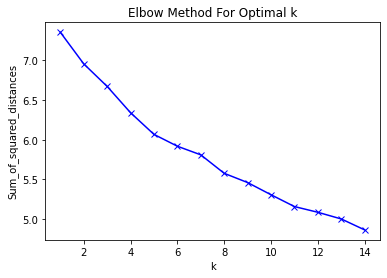

In [183]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [184]:
# set number of clusters
kclusters = 5
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 4, 2, 1, 0, 1, 0, 2, 0], dtype=int32)

In [185]:
# add clustering labels
cities_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
merged = top_cities
# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
merged = merged.join(cities_venues_sorted.set_index('City'), on='City')

merged.head() # check the last columns!

,City,Country,lat,lng,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hong Kong,Hong Kong,22.3050,114.1850,0,Chinese Restaurant,Japanese Restaurant,Dessert Shop,Pool,Noodle House,Buffet,Snack Place,Toy / Game Store,Cha Chaan Teng,Shabu-Shabu Restaurant
1,Bangkok,Thailand,13.7500,100.5167,0,Noodle House,Chinese Restaurant,Asian Restaurant,Thai Restaurant,Burger Joint,Beer Bar,Lounge,Satay Restaurant,Gym / Fitness Center,Hotpot Restaurant
2,London,United Kingdom,51.5072,-0.1275,1,Bakery,Garden,Coffee Shop,Cosmetics Shop,Lounge,Italian Restaurant,Steakhouse,Art Museum,Plaza,Sushi Restaurant
3,Macau,Macau,22.2030,113.5450,2,Portuguese Restaurant,Park,Café,Japanese Restaurant,Chinese Restaurant,Plaza,Thai Restaurant,Coffee Shop,Dessert Shop,Cantonese Restaurant
4,Singapore,Singapore,1.3000,103.8000,0,Food Court,Chinese Restaurant,Café,Indian Restaurant,Pool,Pet Store,Fried Chicken Joint,Flower Shop,Thai Restaurant,Market


In [189]:
# create map
map_clusters = folium.Map(location=[0, 0], zoom_start= 2)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(merged['lat'], merged['lng'], merged['City'], merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [191]:
merged.loc[merged['Cluster Labels'] == 0, merged.columns[[0] + list(range(5, merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Hong Kong,Chinese Restaurant,Japanese Restaurant,Dessert Shop,Pool,Noodle House,Buffet,Snack Place,Toy / Game Store,Cha Chaan Teng,Shabu-Shabu Restaurant
1,Bangkok,Noodle House,Chinese Restaurant,Asian Restaurant,Thai Restaurant,Burger Joint,Beer Bar,Lounge,Satay Restaurant,Gym / Fitness Center,Hotpot Restaurant
4,Singapore,Food Court,Chinese Restaurant,Café,Indian Restaurant,Pool,Pet Store,Fried Chicken Joint,Flower Shop,Thai Restaurant,Market
11,Antalya,Motorcycle Shop,Furniture / Home Store,Turkish Restaurant,Department Store,Auto Garage,Diner,Buffet,Hobby Shop,Gym,Park
12,Shenzhen,Shopping Mall,Italian Restaurant,Café,Nightclub,Lounge,Thai Restaurant,Supermarket,Japanese Restaurant,Department Store,Turkish Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
143,Tianjin,Shopping Mall,Italian Restaurant,German Restaurant,Thai Restaurant,Electronics Store,Department Store,Restaurant,Buffet,Supermarket,Mexican Restaurant
144,Qingdao,Shopping Mall,Bar,Italian Restaurant,Dumpling Restaurant,Coffee Shop,Supermarket,Beer Garden,Harbor / Marina,Turkish Restaurant,Hotel
145,Philadelphia,Breakfast Spot,Art Gallery,Food,Italian Restaurant,Ice Cream Shop,Golf Course,Caribbean Restaurant,Mobile Phone Shop,Food Court,Halal Restaurant
146,Philadelphia,Breakfast Spot,Art Gallery,Food,Italian Restaurant,Ice Cream Shop,Golf Course,Caribbean Restaurant,Mobile Phone Shop,Food Court,Halal Restaurant


In [193]:
merged.loc[merged['Cluster Labels'] == 1, merged.columns[[0] + list(range(5, merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,London,Bakery,Garden,Coffee Shop,Cosmetics Shop,Lounge,Italian Restaurant,Steakhouse,Art Museum,Plaza,Sushi Restaurant
5,Paris,Art Gallery,Coffee Shop,French Restaurant,Pastry Shop,Ice Cream Shop,Garden,Burger Joint,Art Museum,Gourmet Shop,Bistro
7,New York City,Coffee Shop,Park,Italian Restaurant,Café,Gym / Fitness Center,Shopping Mall,Diner,Ice Cream Shop,Clothing Store,Plaza
14,Phuket,Thai Restaurant,Coffee Shop,Park,Bookstore,Chinese Restaurant,Bar,Italian Restaurant,Restaurant,Ice Cream Shop,Bistro
15,Rome,Sandwich Place,Plaza,Italian Restaurant,Pizza Place,Wine Bar,Ice Cream Shop,Restaurant,Bakery,Trattoria/Osteria,Scenic Lookout
19,Mecca,Middle Eastern Restaurant,Burger Joint,Supermarket,Restaurant,Coffee Shop,Mountain,Cosmetics Shop,Ice Cream Shop,Breakfast Spot,Trail
22,Medina,History Museum,Café,Shopping Mall,Coffee Shop,Middle Eastern Restaurant,Breakfast Spot,Dessert Shop,Seafood Restaurant,Bagel Shop,Fried Chicken Joint
24,Amsterdam,Canal,Sandwich Place,Breakfast Spot,Café,Cheese Shop,Bar,Clothing Store,Bookstore,Restaurant,Plaza
34,Barcelona,Tapas Restaurant,Plaza,Spanish Restaurant,Wine Bar,Bar,Dessert Shop,Coffee Shop,Ice Cream Shop,Italian Restaurant,Japanese Restaurant
35,Los Angeles,Scenic Lookout,Park,Shoe Store,Speakeasy,Furniture / Home Store,Botanical Garden,Trail,Café,History Museum,Food Court


In [194]:
merged.loc[merged['Cluster Labels'] == 2, merged.columns[[0] + list(range(5, merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Macau,Portuguese Restaurant,Park,Café,Japanese Restaurant,Chinese Restaurant,Plaza,Thai Restaurant,Coffee Shop,Dessert Shop,Cantonese Restaurant
6,Dubai,Café,Middle Eastern Restaurant,Asian Restaurant,Coffee Shop,Women's Store,Art Gallery,Dim Sum Restaurant,Shopping Mall,Restaurant,Breakfast Spot
9,Istanbul,Turkish Restaurant,Café,Restaurant,Clothing Store,Seafood Restaurant,Gym,Kebab Restaurant,Hotel,Doner Restaurant,Department Store
21,Prague,Café,Ice Cream Shop,Italian Restaurant,Bistro,Outdoor Sculpture,Plaza,Art Gallery,Steakhouse,History Museum,Mexican Restaurant
32,Ho Chi Minh City,Café,Japanese Restaurant,Vietnamese Restaurant,Shopping Mall,Supermarket,Coffee Shop,Movie Theater,Lounge,Golf Course,Sushi Restaurant
39,Johor Bahru,Café,Coffee Shop,Clothing Store,Ice Cream Shop,Boutique,Malay Restaurant,Noodle House,Thai Restaurant,Chinese Restaurant,Bakery
40,Jaipur,Café,Indian Restaurant,Coffee Shop,Bakery,Shopping Mall,Ice Cream Shop,Restaurant,Palace,Tea Room,Bookstore
51,Dublin,Café,Pub,Restaurant,Coffee Shop,Burrito Place,Plaza,Bookstore,Clothing Store,Bakery,Park
53,Hanoi,Vietnamese Restaurant,Café,Vegetarian / Vegan Restaurant,Himalayan Restaurant,Lounge,Sandwich Place,BBQ Joint,Hotel,Bistro,Board Shop
55,Johannesburg,Coffee Shop,Café,Indian Restaurant,Theater,Deli / Bodega,Nightclub,Asian Restaurant,Science Museum,Restaurant,Bar


In [195]:
merged.loc[merged['Cluster Labels'] == 3, merged.columns[[0] + list(range(5, merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
73,San Francisco,Trail,Theater,Playground,Art Gallery,Sandwich Place,Zhejiang Restaurant,Fountain,Flea Market,Flower Shop,Food


In [196]:
merged.loc[merged['Cluster Labels'] == 4, merged.columns[[0] + list(range(5, merged.shape[1]))]]

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Kuala Lumpur,Indian Restaurant,Malay Restaurant,Café,Food Truck,Chinese Restaurant,Flower Shop,Bakery,Dessert Shop,Gym,Noodle House
10,Delhi,Indian Restaurant,Café,Chinese Restaurant,Flea Market,Donut Shop,Lounge,Dessert Shop,Plaza,Bar,Tibetan Restaurant
13,Mumbai,Indian Restaurant,Dessert Shop,Chinese Restaurant,Movie Theater,Ice Cream Shop,Department Store,Harbor / Marina,Electronics Store,Café,Fish Market
25,Agra,Indian Restaurant,Hotel,Multicuisine Indian Restaurant,Market,Mughlai Restaurant,Bistro,South Indian Restaurant,Arts & Crafts Store,Indian Sweet Shop,Italian Restaurant
37,Chennai,Indian Restaurant,Sandwich Place,Bookstore,Farmers Market,Vegetarian / Vegan Restaurant,Café,Italian Restaurant,Breakfast Spot,Market,Middle Eastern Restaurant
65,Dammam,Indian Restaurant,Middle Eastern Restaurant,Burger Joint,Fast Food Restaurant,Restaurant,Seafood Restaurant,Park,Bakery,Supermarket,Fried Chicken Joint
70,Vancouver,Market,Bakery,Smoke Shop,Vietnamese Restaurant,Tea Room,Indian Restaurant,Filipino Restaurant,Bagel Shop,Diner,Park
135,Pune,Indian Restaurant,Vegetarian / Vegan Restaurant,Snack Place,Dessert Shop,Burger Joint,Donut Shop,Seafood Restaurant,Ice Cream Shop,Café,Bar
